In [1]:
from lib_linear import *
import  time
import torch.nn.functional as F

## Data

In [2]:
mean, std = calculate_mean_and_std()
train_data, test_data =  download_normalized_data(mean, std)

## model

In [3]:
class CustomNetworkUniform(object):
    
    """
    Simple D-layer linear neural network 
    hidden_dims = topule(n0, n1, n2, ...nD)
    n0 = input layer
    n_D = output layer
    """
    
    def __init__(self, D, layers_dim, weights, biases):
        
        """
        Initialize network's weights according to Gaussian iid and network's biases with 0.0 values
        """
        
        w1,w2,w3,w4 = weights
        b1,b2,b3,b4 = biases
        self.weights = []
        self.biases = []
        
        self.D = len(layers_dim)-1
        assert self.D == D
    
        print("Depth of the network = number of hidden layers + 1:", D)
        
        weight1: torch.Tensor =  torch.reshape(w1, (layers_dim[1], layers_dim[0]))               
        weight2: torch.Tensor =  torch.reshape(w2, (layers_dim[2], layers_dim[1]))                    
        weight3: torch.Tensor =  torch.reshape(w3, (layers_dim[3], layers_dim[2]))
        weight4: torch.Tensor =  torch.reshape(w4, (layers_dim[4], layers_dim[3]))                    
        
        bias1: torch.Tensor =  b1              
        bias2: torch.Tensor =  b2                  
        bias3: torch.Tensor =  b3
        bias4: torch.Tensor =  b4                  
            
        weight1.requires_grad = True        
        weight2.requires_grad = True        
        weight3.requires_grad = True
        weight4.requires_grad = True        
        
        bias1.requires_grad = True   
        bias2.requires_grad = True   
        bias3.requires_grad = True   
        bias4.requires_grad = True   
        
        self.weights.append(weight1)        
        self.weights.append(weight2)       
        self.weights.append(weight3)
        self.weights.append(weight4)        
       
        self.biases.append(bias1)        
        self.biases.append(bias2)       
        self.biases.append(bias3)
        self.biases.append(bias4)        
            
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network
        """

        for i in range(0,self.D):            
            x = torch.nn.functional.linear( input = x, weight=self.weights[i])
            x = torch.tanh(x)
        return x 
    
    
    
    def parameters(self) -> List[torch.Tensor]:
        """
        Returns all trainable parameters 
        """
        return self.weights + self.biases

In [4]:
def get_landscape(path):
    
    w1 = torch.Tensor(pd.read_csv(path + 'w1.csv')['w1'])
    w2 = torch.Tensor(pd.read_csv(path + 'w2.csv')['w2'])
    w3 = torch.Tensor(pd.read_csv(path + 'w3.csv')['w3'])
    w4 = torch.Tensor(pd.read_csv(path + 'w4.csv')['w4'])

    b1 = torch.Tensor(pd.read_csv(path + 'b1.csv')['b1'])
    b2 = torch.Tensor(pd.read_csv(path + 'b2.csv')['b2'])
    b3 = torch.Tensor(pd.read_csv(path + 'b3.csv')['b3'])
    b4 = torch.Tensor(pd.read_csv(path + 'b4.csv')['b4'])
    
    weights = (w1,w2,w3,w4)
    biases = (b1,b2,b3,b4)
    
    input_dim = 784
    output_dim = 10
    hidden_dim1 = 50
    hidden_dim2 = 50
    hidden_dim3 = 50
    
    D = 4
    # initialize the model
    model: CustomNetworkUniform = CustomNetworkUniform(D = D, 
                                                       layers_dim = (input_dim, hidden_dim1, hidden_dim2,hidden_dim3, output_dim),
                                                       weights=weights,
                                                       biases = biases)
    criterion = nn.CrossEntropyLoss()

    CE_tab=[]
    batch_size: int = 1  
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    
    with torch.no_grad():
        for i, (x,y) in enumerate(train_loader):
            y_model = model(x)
            CE = criterion(y_model, y)
            CE_tab.append(float(CE))

    mean_CE = sum(CE_tab)/len(CE_tab)
    print(path)
    print("Cross Entropy evaluated on training set CE = {:.6f} ".format(mean_CE))
    
    fig, axs = plt.subplots(1,2, figsize = (12, 4))
    axs[0].plot(CE_tab, color = 'indigo',linewidth=0.2)
    axs[0].set_xlabel('n', fontsize=12)
    axs[0].set_ylabel('Cross entropy', fontsize=12)
    axs[0].grid(True,alpha = .3)
    axs[1].hist(CE_tab, bins =100, color = 'indigo', density = True);
    axs[1].grid(True, alpha = .3)

    fig.tight_layout()
    plt.show()
    
    
    
    CE_tab=[]
    batch_size: int = 1  
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    
    with torch.no_grad():
        for i, (x,y) in enumerate(test_loader):
            y_model = model(x)
            CE = criterion(y_model, y)
            CE_tab.append(float(CE))

    mean_CE = sum(CE_tab)/len(CE_tab)
    print(path)
    print("Cross Entropy evaluated on testing set CE = {:.6f} ".format(mean_CE))
    
    fig, axs = plt.subplots(1,2, figsize = (12, 4))
    axs[0].plot(CE_tab, color = 'indigo',linewidth=0.2)
    axs[0].set_xlabel('n', fontsize=12)
    axs[0].set_ylabel('Cross entropy', fontsize=12)
    axs[0].grid(True,alpha = .3)
    axs[1].hist(CE_tab, bins =100, color = 'indigo', density = True);
    axs[1].grid(True, alpha = .3)

    fig.tight_layout()
    plt.show()

## CHECK:  $$MSE = \frac{1}{P} \sum_{\mu=1}^P \lVert y-\hat{y} \rVert ^2 $$

$$ MSE= \frac{1}{P} \sum_{\mu=1}^P  \lVert y - W^2 W^1 x \rVert ^2 $$

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform/params set 1/
Cross Entropy evaluated on training set CE = 0.900501 


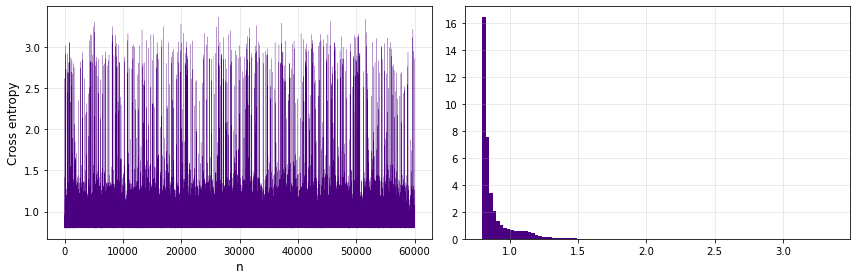

3 hidden layers/uniform/params set 1/
Cross Entropy evaluated on testing set CE = 0.907928 


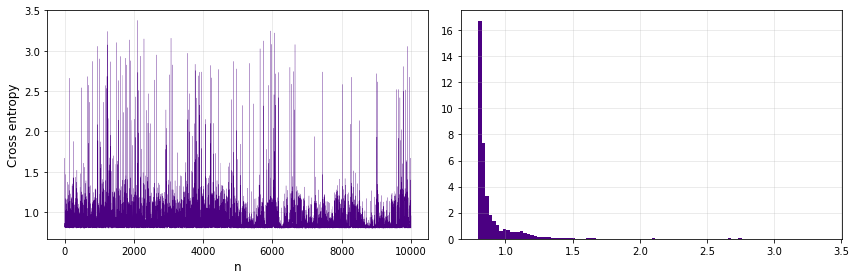

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform/params set 2/
Cross Entropy evaluated on training set CE = 0.919518 


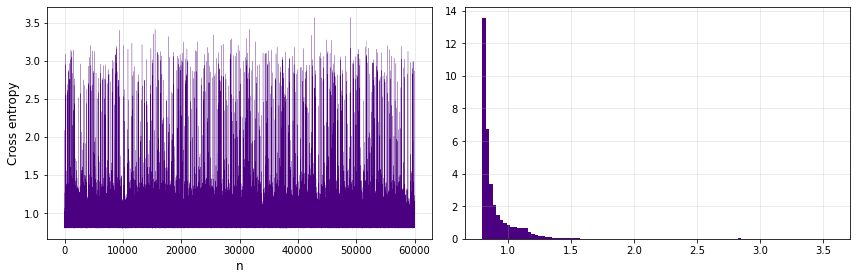

3 hidden layers/uniform/params set 2/
Cross Entropy evaluated on testing set CE = 0.924607 


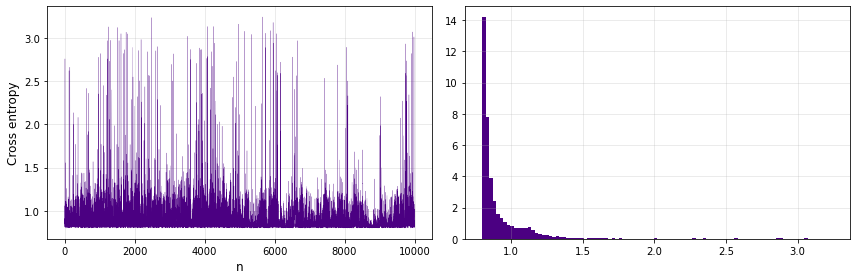

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform/params set 3/
Cross Entropy evaluated on training set CE = 0.912661 


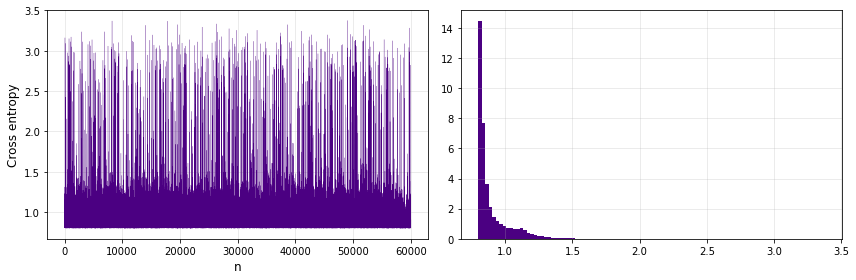

3 hidden layers/uniform/params set 3/
Cross Entropy evaluated on testing set CE = 0.917328 


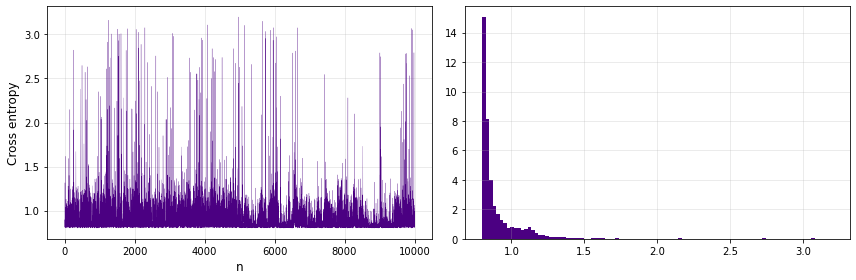

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform/params set 4/
Cross Entropy evaluated on training set CE = 0.887683 


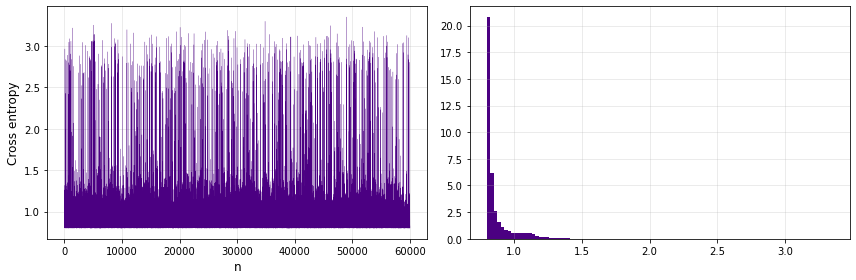

3 hidden layers/uniform/params set 4/
Cross Entropy evaluated on testing set CE = 0.893281 


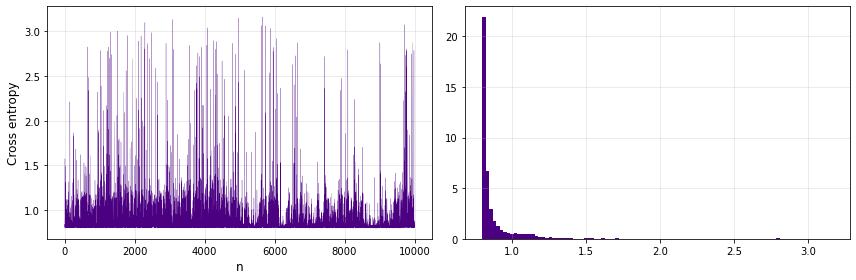

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform/params set 5/
Cross Entropy evaluated on training set CE = 0.908785 


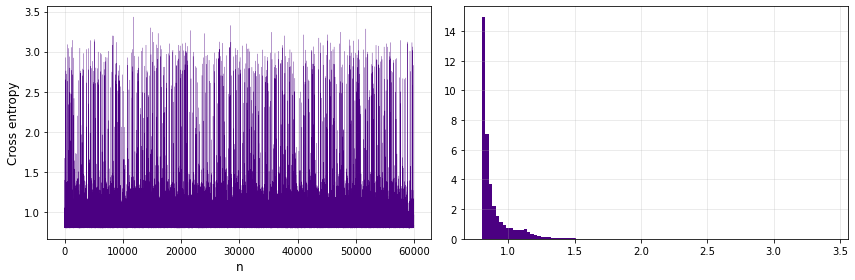

3 hidden layers/uniform/params set 5/
Cross Entropy evaluated on testing set CE = 0.918363 


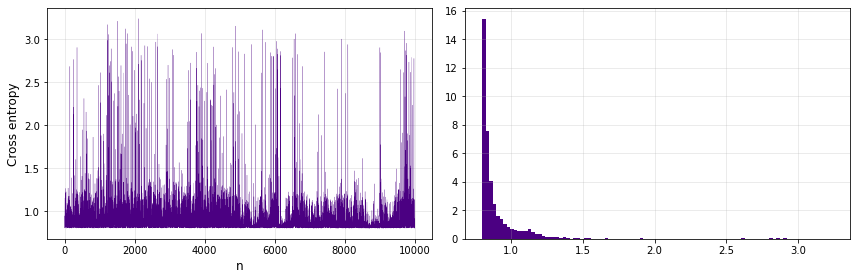

In [5]:
for i in range(1,6):
    path = '3 hidden layers/uniform/params set {:}/'.format(i)
    get_landscape(path)

# UNIFORM SMALL

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform_small/params set 1/
Cross Entropy evaluated on training set CE = 0.978315 


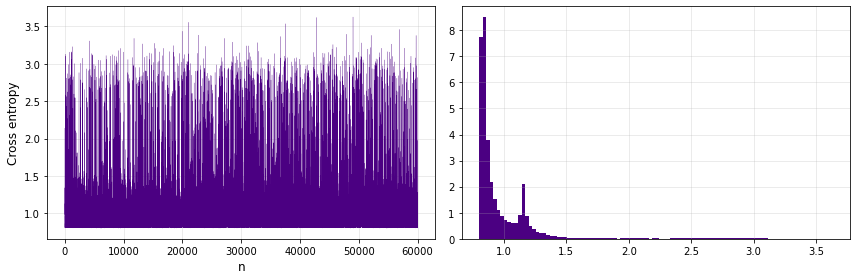

3 hidden layers/uniform_small/params set 1/
Cross Entropy evaluated on testing set CE = 0.981335 


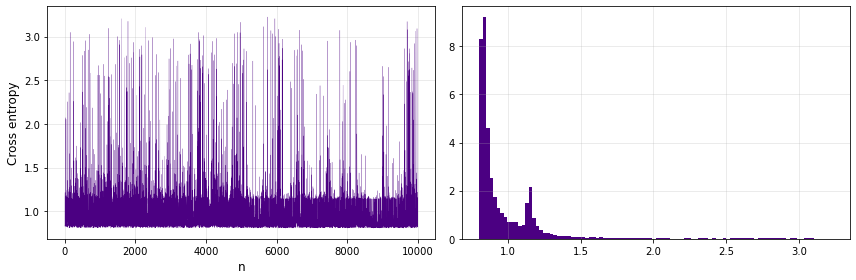

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform_small/params set 2/
Cross Entropy evaluated on training set CE = 0.978799 


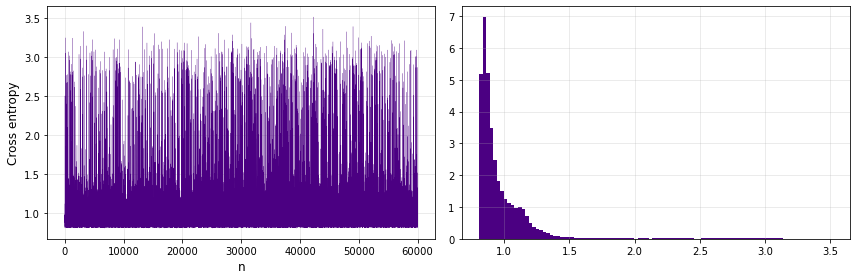

3 hidden layers/uniform_small/params set 2/
Cross Entropy evaluated on testing set CE = 0.980313 


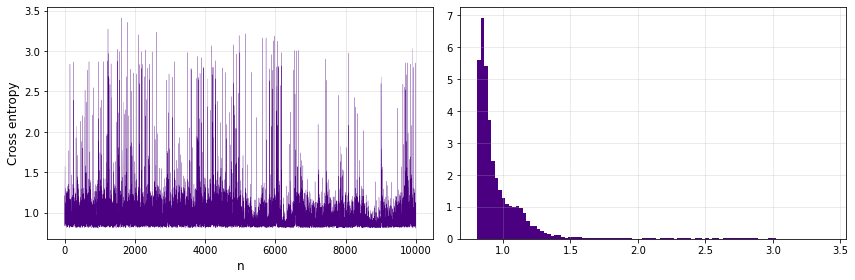

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform_small/params set 3/
Cross Entropy evaluated on training set CE = 0.943451 


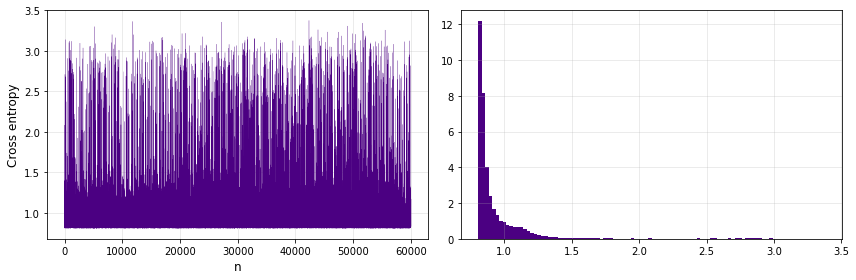

3 hidden layers/uniform_small/params set 3/
Cross Entropy evaluated on testing set CE = 0.943361 


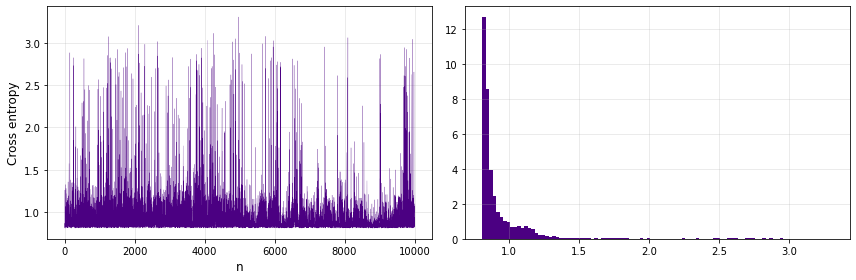

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform_small/params set 4/
Cross Entropy evaluated on training set CE = 0.948904 


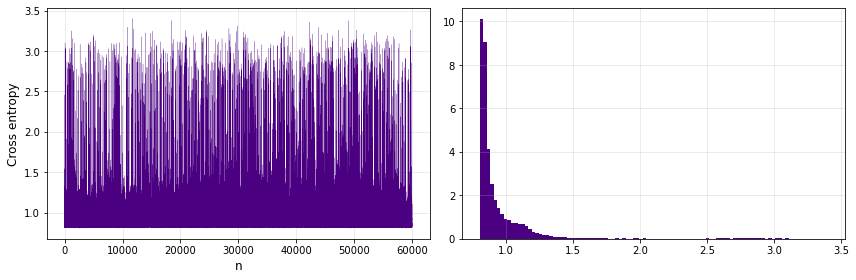

3 hidden layers/uniform_small/params set 4/
Cross Entropy evaluated on testing set CE = 0.950830 


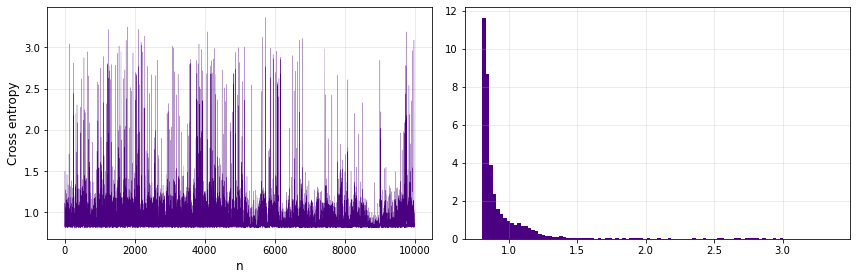

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/uniform_small/params set 5/
Cross Entropy evaluated on training set CE = 0.959945 


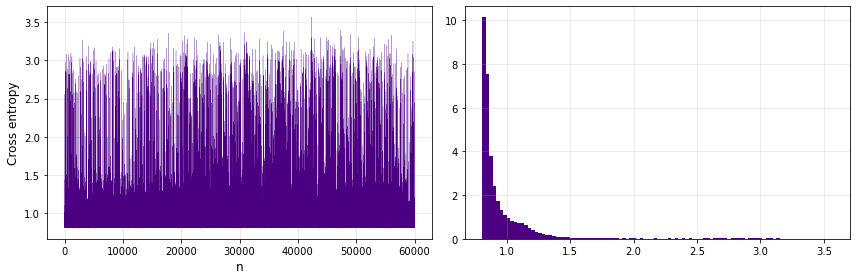

3 hidden layers/uniform_small/params set 5/
Cross Entropy evaluated on testing set CE = 0.963075 


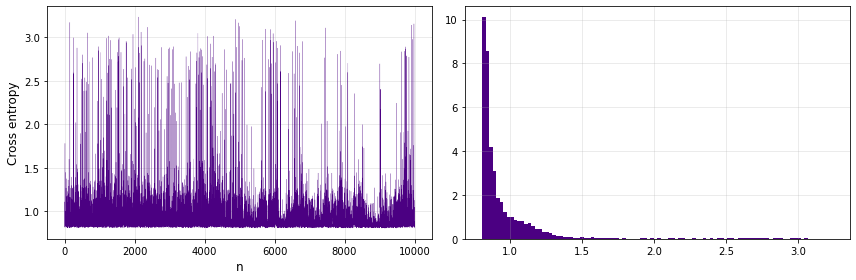

In [6]:
for i in range(1,6):
    path = '3 hidden layers/uniform_small/params set {:}/'.format(i)
    get_landscape(path)

# Normal weight initialization

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/normal/parameters set 1/
Cross Entropy evaluated on training set CE = 1.483304 


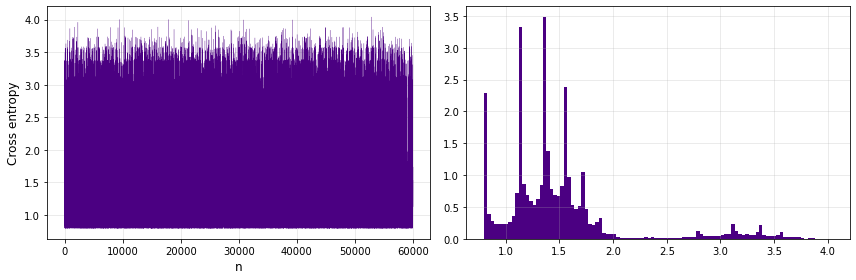

3 hidden layers/normal/parameters set 1/
Cross Entropy evaluated on testing set CE = 1.560340 


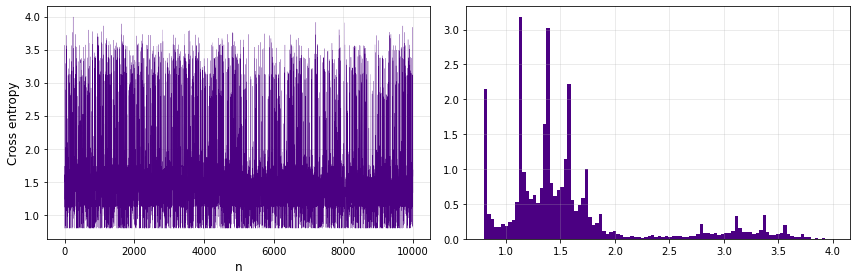

In [8]:
path = '3 hidden layers/normal/parameters set 1/'.format(i)
get_landscape(path)

# Normal small

Depth of the network = number of hidden layers + 1: 4
3 hidden layers/normal_small/parameters set 5/
Cross Entropy evaluated on training set CE = 2.618821 


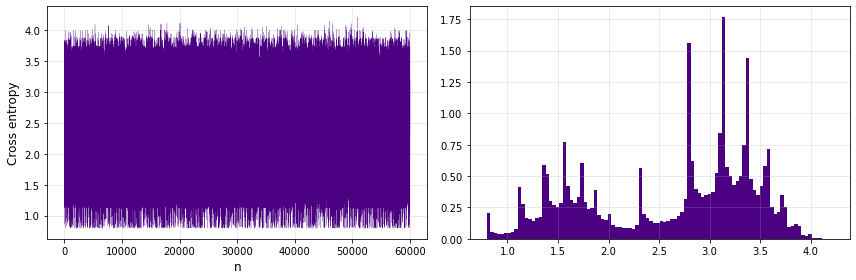

3 hidden layers/normal_small/parameters set 5/
Cross Entropy evaluated on testing set CE = 2.618234 


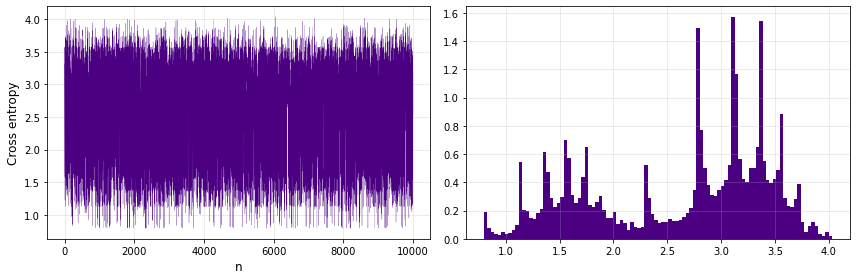

In [9]:
path = '3 hidden layers/normal_small/parameters set 5/'.format(i)
get_landscape(path)